# UCI regression 

In [1]:
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from jax.sharding import PositionalSharding
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
from time import time
from tqdm import tqdm

In [3]:
devices = jax.devices()
sharding = PositionalSharding(devices)

In [61]:
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 18

cmap = {
    "E-ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet",
    "O-EKF": "darkorange",
}

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45731, 10)
naval-propulsion-plant (11935, 18)
wine-quality-red (1600, 12)
bostonHousing (507, 14)
power-plant (9569, 5)
concrete (1031, 9)
energy (769, 9)
kin8nm (8193, 9)
yacht (309, 7)


In [7]:
dataset_name = "naval-propulsion-plant"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 100
v_error = 50
seed_init = 314
p_error = 0.30
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_type == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [8]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(100, 10742, 17)

In [9]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [10]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [11]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [12]:
Q = 0.0
observation_covariance = 1.0

In [13]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

In [14]:
X_collection.shape

(100, 10742, 17)

## EKF

In [15]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    agent = gfilter.ExtendedKalmanFilter(
        lambda x: x,
        model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance  * jnp.eye(1),
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2)
    res = np.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [16]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 2         | -5.106    | -2.057    |
| 3         | -2.808    | -3.675    |
| 6         | -1.612    | -3.692    |
| 8         | -1.608    | -3.742    |
CPU times: user 20.4 s, sys: 22.1 s, total: 42.6 s
Wall time: 7.41 s


In [17]:
%%time

lr = np.exp(bo.max["params"]["log_lr"])
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))
res = scanfn(bel_init, y_collection, X_collection, callback)

res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 2.04 s, sys: 35.4 ms, total: 2.08 s
Wall time: 9.61 s


In [18]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]

CPU times: user 58.9 s, sys: 1.44 s, total: 1min
Wall time: 1min 5s


In [19]:
time_runs_ekf = pd.Series(time_runs, name="EKF")
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)

/tmp/ipykernel_42274/1561462852.py:2: RuntimeWarning: overflow encountered in power
  err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)


## WLF-IMQ

### Hparam choice

In [20]:
def filter_imqf(soft_threshold, log_lr):
    lr = np.exp(log_lr)
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold, log_lr):
    # res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [21]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 15),
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 3         | -0.04949  | -0.41     | 12.41     |
| 7         | -0.04011  | 0.0       | 10.67     |
| 8         | -0.03715  | 0.0       | 6.117     |
CPU times: user 23.9 s, sys: 23.9 s, total: 47.8 s
Wall time: 9.87 s


### Eval

In [22]:
soft_threshold = bo.max["params"]["soft_threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [23]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

CPU times: user 2.3 s, sys: 75.4 ms, total: 2.38 s
Wall time: 9.97 s


In [24]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]

CPU times: user 51.7 s, sys: 1.4 s, total: 53.1 s
Wall time: 1min 4s


In [25]:
time_runs_wlf = pd.Series(time_runs, name="WLF-IMQ")
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## Inverse-Wishart-based EKF
(Agamenoni 2012)

### Hparam choice

In [26]:
def filter_rkf(noise_scaling, log_lr):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=2
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [27]:
def opt_step(noise_scaling, log_lr):
    # res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [28]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 3         | -0.03151  | -0.41     | 12.41     |
| 5         | -0.0286   | -0.4412   | 3.911     |
CPU times: user 27.1 s, sys: 23.7 s, total: 50.8 s
Wall time: 13.5 s


### Eval

In [29]:
noise_scaling = bo.max["params"]["noise_scaling"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=2,
    noise_scaling=noise_scaling,
)

In [30]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = jax.block_until_ready(yhat_collection_ann1.squeeze())

CPU times: user 3.74 s, sys: 49.8 ms, total: 3.79 s
Wall time: 27.5 s


In [31]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]

CPU times: user 1min 35s, sys: 1.92 s, total: 1min 37s
Wall time: 2min


In [32]:
time_runs_ann1 = pd.Series(time_runs, name="E-ANN-1")
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

/tmp/ipykernel_42274/2309023158.py:2: RuntimeWarning: overflow encountered in power
  err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)


## WLF-MD
Weighted likelihood filter with Mahalanobis distance thresholding weighting function

### Hparam section

In [33]:
def filter_mah_ekf(log_lr, threshold):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

def opt_step(log_lr, threshold):
    res = -jnp.power(filter_mah_ekf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [34]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "threshold": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
CPU times: user 24 s, sys: 24.1 s, total: 48.1 s
Wall time: 8.38 s


### Eval

In [35]:
threshold = bo.max["params"]["threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [36]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))

_, yhat_collection_mekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 2.64 s, sys: 65.9 ms, total: 2.7 s
Wall time: 10 s


In [37]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]

CPU times: user 1min 8s, sys: 2.41 s, total: 1min 10s
Wall time: 1min 16s


In [38]:
time_runs_mekf = pd.Series(time_runs, name="WLF-MD")
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## O-EKF
Outlier-based extended Kalman filter

In [39]:
def filter_oekf(log_lr, alpha, beta):
    """
    Outlier ekf
    """
    lr = np.exp(log_lr)
    agent_wang2018 = rfilter.OutlierDetectionExtendedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        # tol_inner=1e-3 # refactor
        n_inner=2
    )
    
    bel_init = agent_wang2018.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_wang2018.vobs_fn)
    
    bel_oekf, yhat_pp = agent_wang2018.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_wang2018, bel_oekf)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, alpha, beta):
    res = -jnp.power(filter_oekf(log_lr, alpha, beta)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [40]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |   alpha   |   beta    |  log_lr   |
-------------------------------------------------------------
| 2         | -0.09679  | 3.916     | 4.59      | -0.8632   |
| 3         | -0.0714   | 3.64      | 1.302     | -0.4412   |
| 7         | -0.04398  | 5.0       | 0.1547    | 0.0       |
CPU times: user 27.6 s, sys: 24.8 s, total: 52.3 s
Wall time: 15.9 s


### Eval

In [41]:
log_lr = bo.max["params"]["log_lr"]
lr_oekf = np.exp(log_lr)
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]

agent = rfilter.OutlierDetectionExtendedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        # tol_inner=1e-3 # refactor
        n_inner=2
    )


In [42]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.jit(jax.vmap(agent.scan, in_axes=(None, 0, 0, None)), static_argnames=("callback_fn",))

_, yhat_collection_oekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_oekf = jax.block_until_ready(yhat_collection_oekf)
yhat_collection_oekf = yhat_collection_oekf.squeeze()

CPU times: user 2.87 s, sys: 75.7 ms, total: 2.95 s
Wall time: 17.9 s


In [43]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]

CPU times: user 1min 51s, sys: 2.83 s, total: 1min 54s
Wall time: 2min 32s


In [44]:
time_runs_oekf = pd.Series(time_runs, name="O-EKF")
err_collection_oekf = pd.DataFrame(np.power(y_collection - yhat_collection_oekf, 2).T)

## Online SGD

In [45]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=X.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )

    callback = partial(callback_fn, applyfn=model.apply)

    bel_init = agent.init_bel(params_init)
    bel_final, yhat_pp = agent.scan(bel_init, y, X, callback)
    out = (agent, bel_final)
    yhat_pp = yhat_pp.squeeze()

    return yhat_pp.squeeze(), out

def opt_step(log_lr, n_inner):
    res = -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [46]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 2         | -3.48     | -3.675    | 8.049     |
| 6         | -0.9316   | -5.0      | 6.913     |
| 7         | -0.6327   | -4.635    | 3.028     |
| 10        | -0.4117   | -5.0      | 1.0       |
CPU times: user 22.7 s, sys: 23.5 s, total: 46.2 s
Wall time: 8.47 s


In [47]:
lr = jnp.exp(bo.max["params"]["log_lr"])
n_inner = int(bo.max["params"]["n_inner"])

agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(lr),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)
jnp.sqrt(jnp.power(errs, 2).mean())

Array(27.506084, dtype=float32)

In [48]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 950 ms, sys: 9.09 ms, total: 959 ms
Wall time: 785 ms


In [49]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]

CPU times: user 40.7 s, sys: 1.22 s, total: 41.9 s
Wall time: 40.7 s


In [50]:
time_runs_ogd = pd.Series(time_runs, name="OGD")
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [51]:
import seaborn as sns

In [52]:
pd.set_option("display.float_format", lambda x: format(x, "0.4f"))

In [53]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "WLF-MD": err_collection_mekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "E-ANN-1": err_collection_ann1.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "O-EKF": err_collection_oekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
})

df_results.describe()

/home/gerardoduran/mambaforge/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,WLF-IMQ,EKF,OGD,WLF-MD,E-ANN-1,O-EKF
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,0.0474,inf,0.4695,0.0410,inf,0.0566
std,0.0020,NaN,0.2530,0.0018,NaN,0.0663
min,0.0437,0.9778,0.1682,0.0366,0.0277,0.0409
25%,0.0458,2.0008,0.2917,0.0397,0.0302,0.0429
50%,0.0472,2.6115,0.4246,0.0407,0.0339,0.0438
75%,0.0488,3.9242,0.5773,0.0421,73658636126265450496.0000,0.0449
max,0.0547,inf,1.6184,0.0458,inf,0.5703


In [75]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.median(axis=0),
    "EKF": err_collection_ekf.median(axis=0),
    "OGD": err_collection_ogd.median(axis=0),
    "WLF-MD": err_collection_mekf.median(axis=0),
    "E-ANN-1": err_collection_ann1.median(axis=0),
    "O-EKF": err_collection_oekf.median(axis=0),
})
df_results = np.sqrt(df_results)
df_results.describe()

,WLF-IMQ,EKF,OGD,WLF-MD,E-ANN-1,O-EKF
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,0.2435,1.3769,0.6229,0.2150,6052788.0000,0.2267
std,0.0072,0.3240,0.1344,0.0078,60488996.0000,0.0174
min,0.2309,0.8275,0.4011,0.1990,0.1589,0.1792
25%,0.2380,1.1570,0.5110,0.2089,0.1712,0.2217
50%,0.2426,1.3177,0.6031,0.2142,0.1833,0.2259
75%,0.2484,1.5279,0.7207,0.2205,0.2915,0.2304
max,0.2666,2.6642,0.9974,0.2379,604893760.0000,0.3567


In [76]:
df_time = pd.concat([
    time_runs_ekf,
    time_runs_wlf,
    time_runs_ann1,
    time_runs_oekf,
    time_runs_ogd,
    time_runs_mekf
], axis=1)

In [77]:
df_all = pd.merge(
    df_results.reset_index().melt("index", value_name="err"),
    df_time.reset_index().melt("index", value_name="time"),
    on=["index", "variable"],
)

df_all

,index,variable,err,time
0,0,WLF-IMQ,0.2408,0.6510
1,1,WLF-IMQ,0.2563,0.6416
2,2,WLF-IMQ,0.2354,0.6548
3,3,WLF-IMQ,0.2467,0.6400
4,4,WLF-IMQ,0.2527,0.6391
...,...,...,...,...
595,95,O-EKF,0.2302,1.5278
596,96,O-EKF,0.2211,1.5133
597,97,O-EKF,0.2334,1.5156
598,98,O-EKF,0.2292,1.5148


In [90]:
summary = df_all.pivot_table(index="variable", values=["err", "time"], aggfunc="median")
summary

,err,time
variable,,
E-ANN-1,0.1833,1.1949
EKF,1.3177,0.6301
O-EKF,0.2259,1.5178
OGD,0.6031,0.4013
WLF-IMQ,0.2426,0.6434
WLF-MD,0.2142,0.7607


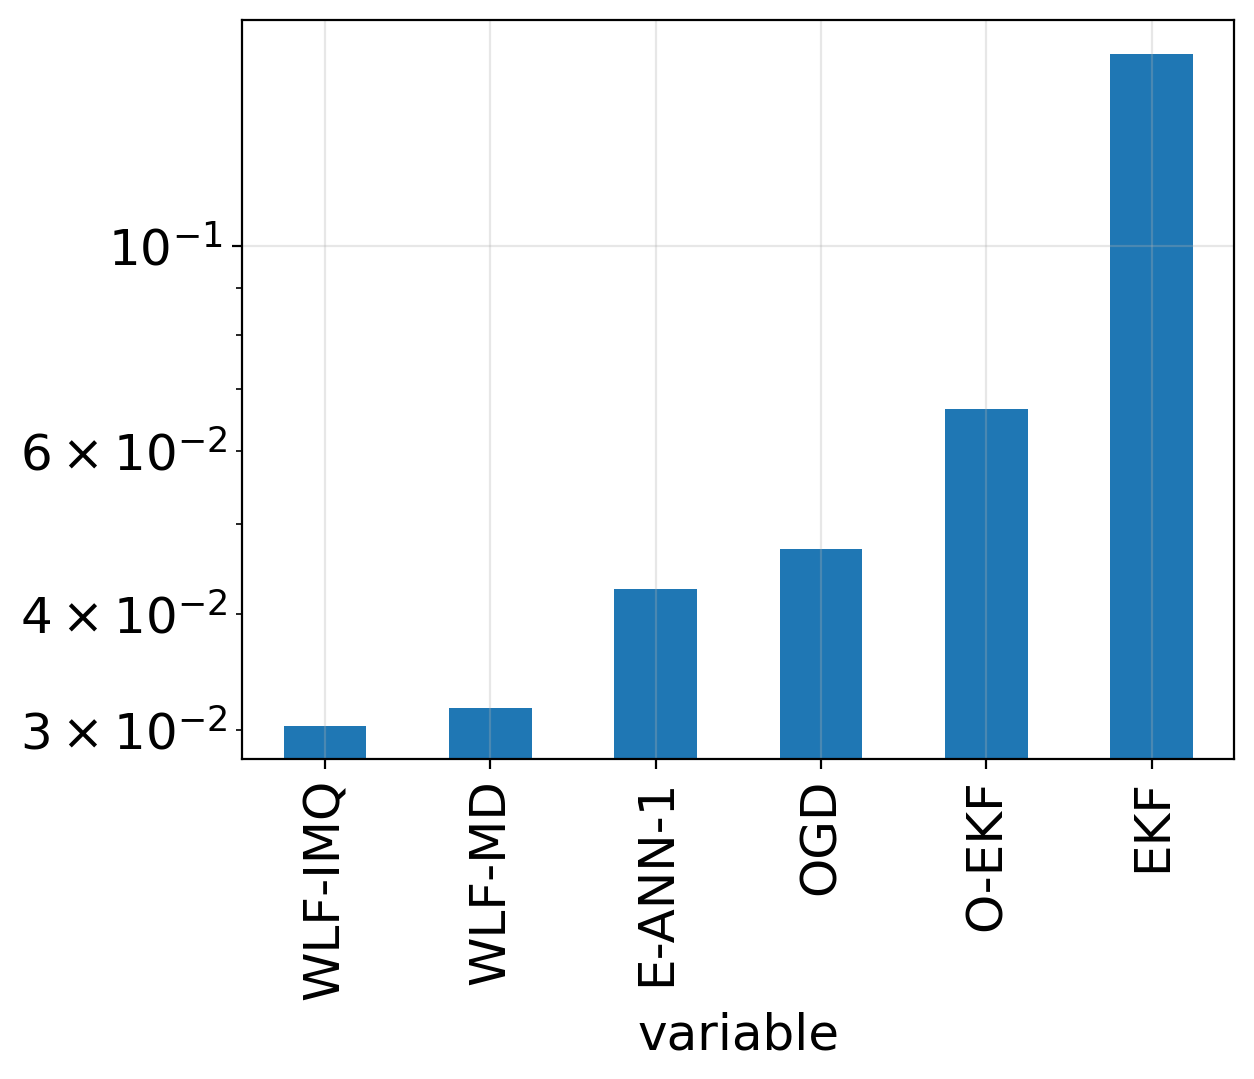

In [104]:
((summary["err"] * summary["time"]) / summary["time"].sum()).sort_values().plot(kind="bar")
plt.grid(alpha=0.3)
plt.yscale("log")

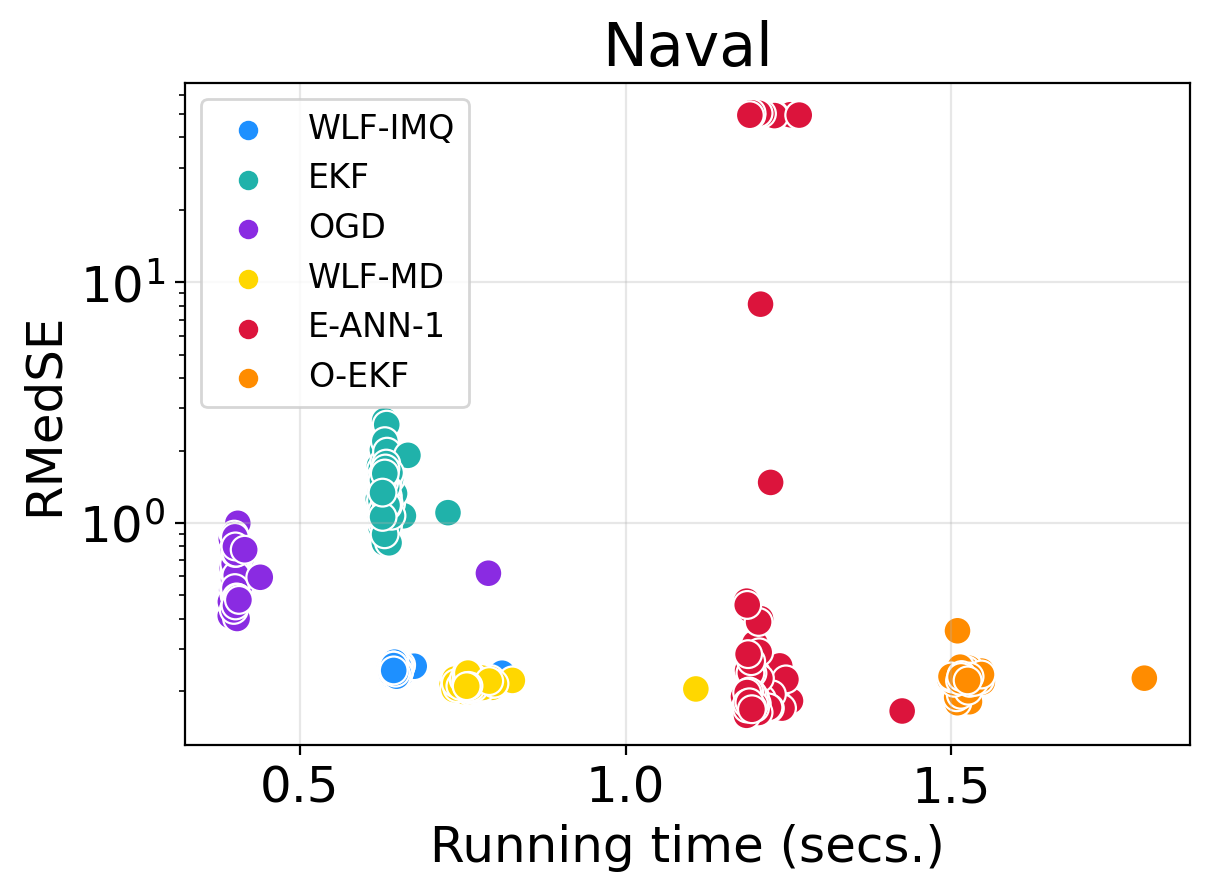

In [122]:
title = dataset_name.split("-")[0]
sns.scatterplot(y="err", x="time", hue="variable", data=df_all.query("err < 10 ** 2"), palette=cmap, s=100)
plt.yscale("log")
plt.legend(ncol=1, loc="upper left", fontsize=12)
plt.title(title.capitalize())
plt.xlabel("Running time (secs.)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{title}-time-v-err.png", dpi=300)

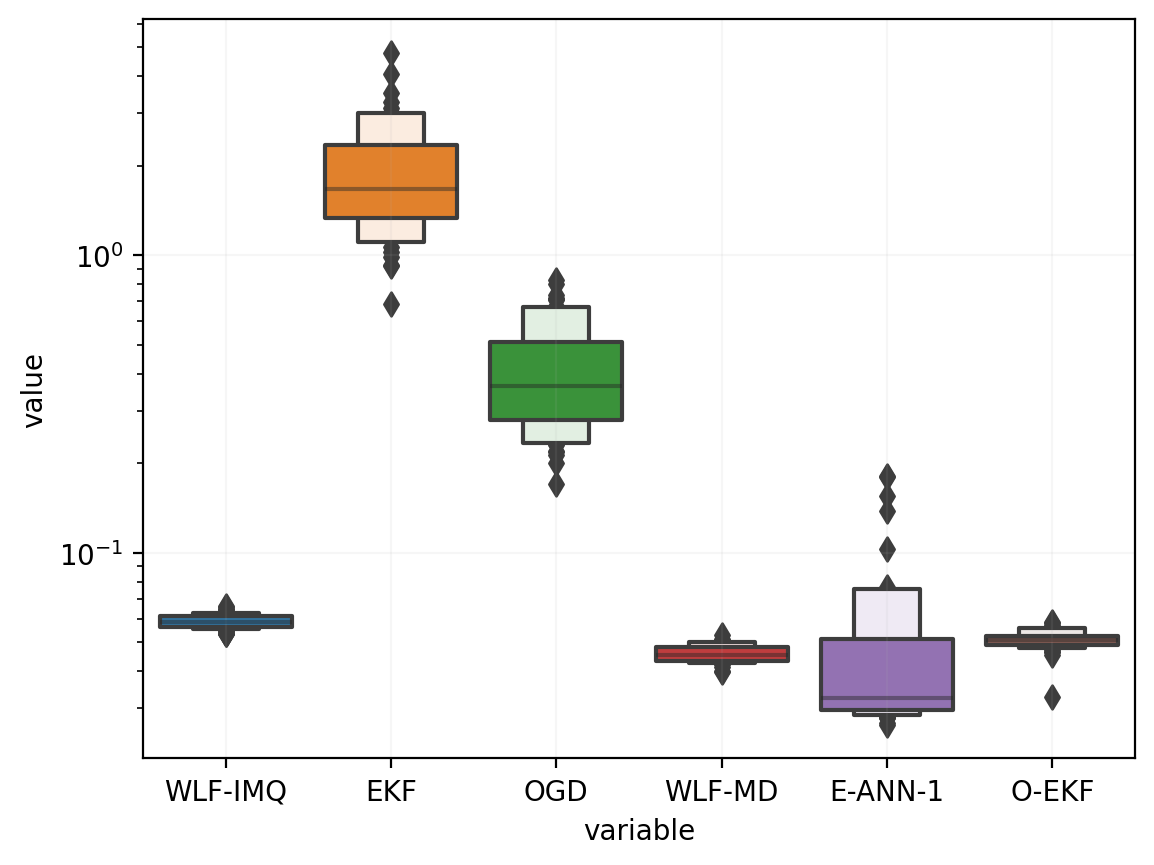

In [65]:
sns.boxenplot(
    x="variable",
    y="value",
    data=df_results.melt().query("value < 5"),
)
plt.yscale("log")
plt.grid(alpha=0.1)

In [66]:
err_collection = {
    "methods": {
        "WLF-IMQ": err_collection_wlf,
        "EKF": err_collection_ekf,
        "OGD": err_collection_ogd,
        "WLF-MD": err_collection_mekf,
        "E-ANN-1": err_collection_ann1
    },
    "config": {
        "mask-clean": mask_clean,
        "p_error": p_error,
    }
}

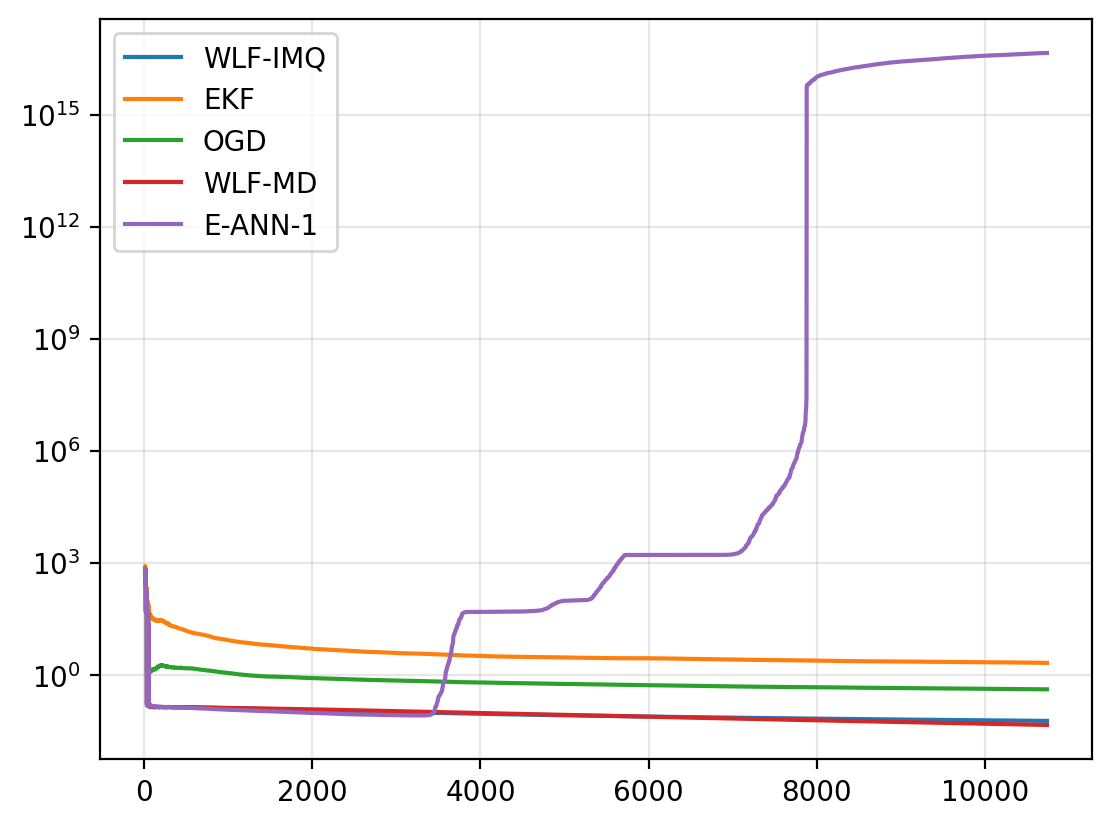

In [69]:
for method in err_collection["methods"]:
    err_collection["methods"][method][10:].expanding().median().mean(axis=1).plot(label=method)
    plt.yscale("log")
    plt.legend()
    plt.grid(alpha=0.3)

In [ ]:
with open(f"./results/{dataset_name}-{noise_type}-p-error{p_error * 100:02.0f}.pkl", "wb") as f:
    pickle.dump(err_collection, f)

## Time analysis